# **ELG 7172B : **: Homework 8 Solutions

The solutions are provided by Issa Ayoub and Xiaoyan Li

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## Ch3 - Question 5
From the book: Bayesian Analysis with Python. <br>
Repeat the exercise we did on the main text with the water quality example,
but this time without hierarchical structure. Just use a flat prior such as Beta
(alpha=1, beta=1). Compare the results of both models.


In [46]:
# generate synthetic data. total number of good quality samples is stored in G_samples, and the total number of samples per
# group is stored in N_samples. 
N_samples =  [30, 30, 30]
G_samples =  [18, 18, 18]

# repeat [0, 1, 2], [30, 30, 30] times. 
group_idx = np.repeat(np.arange(len(N_samples)), N_samples)
data = []  
for i in range(0, len(N_samples)):
    data.extend(np.repeat([1, 0], [G_samples[i], N_samples[i]-G_samples[i]]))

print(data, len(data))

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 90


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_logodds__, beta_log__, alpha_log__]
There were 101 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
There were 139 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.676785445201, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001731D473D68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000017328DFC438>]], dtype=object)

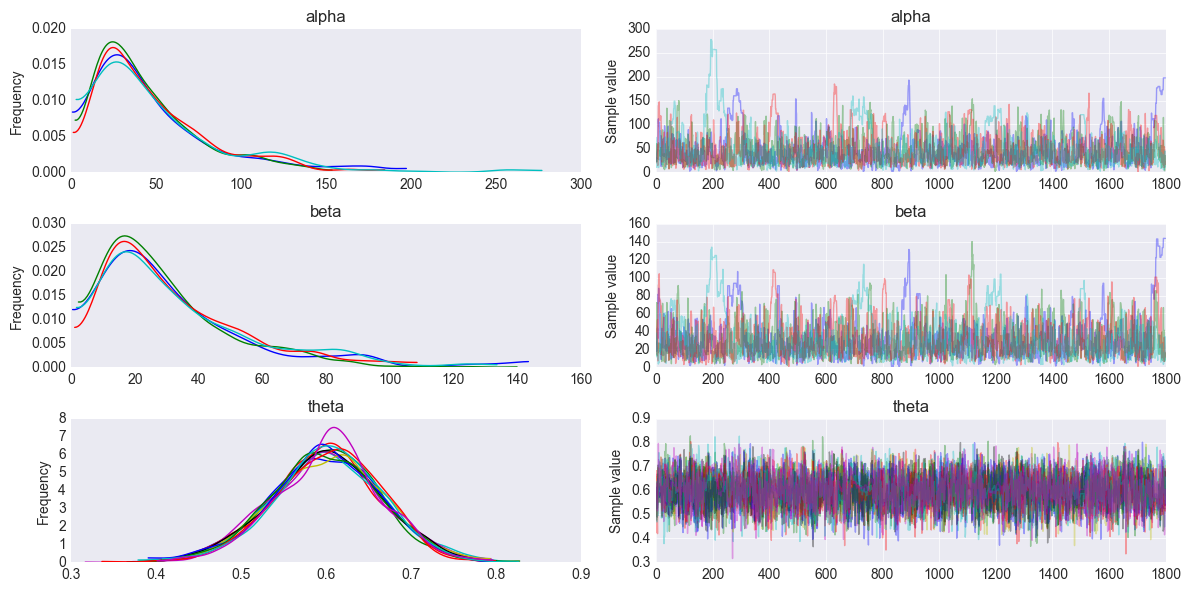

In [56]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=25)
    beta = pm.HalfCauchy('beta', beta=25)
    
    theta = pm.Beta('theta', alpha, beta, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)

    trace_h = pm.sample(2000)

chain_h = trace_h[200:]
pm.traceplot(chain_h)

In [57]:
pm.summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,48.30,36.60,1.92e+00,3.67,123.96,251.0,1.0
beta,31.89,23.19,1.21e+00,2.05,81.58,258.0,1.0
theta__0,0.60,0.07,1.47e-03,0.47,0.73,1695.0,1.0
theta__1,0.60,0.06,1.21e-03,0.46,0.72,2616.0,1.0
theta__2,0.60,0.06,1.36e-03,0.48,0.73,2585.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_logodds__]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000173196B4EF0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001731D31C630>]], dtype=object)

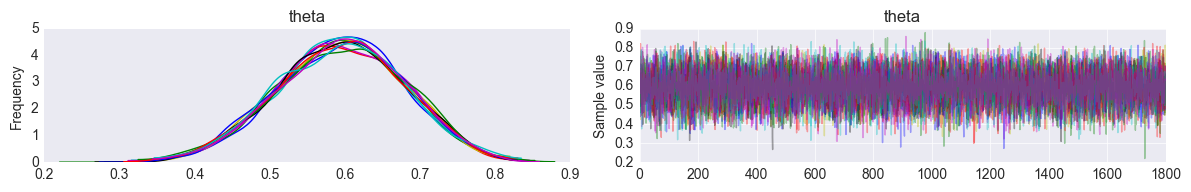

In [50]:
with pm.Model() as model_h:
    
    theta = pm.Beta('theta', alpha=1, beta=1, shape=len(N_samples))
    y = pm.Bernoulli('y', p=theta[group_idx], observed=data)

    trace_h = pm.sample(2000)

chain_h = trace_h[200:]
pm.traceplot(chain_h)

In [52]:
pm.summary(chain_h)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta__0,0.59,0.08,7.35e-04,0.44,0.76,7200.0,1.0
theta__1,0.59,0.09,8.37e-04,0.43,0.76,7200.0,1.0
theta__2,0.59,0.09,8.28e-04,0.43,0.76,7200.0,1.0


In this case we get close results. but this is not always the case. An example is found in Hierarchical linear regression chapter 4. Assume we have some dataset, and this data was divided into 8 groups such that the last group contains only 1 point. Hence, finding alpha and beta that best fit this data point is impossible since we have infinite number of points that can pass through 1 particular point. Therefore, a prior is needed. So we can obtain the prior information from the other 7 groups. In this case, we will find alpha and beta. Finally, fiting the line will be possible in the 8th group. And this particular point will effect the intercept only. 

## Ch 5, Problem 1

From the book: Bayesian Analysis with Python. <br>

Rerun the first model using the variables petal length and then petal width.
What are the main differences in the results? How wide or narrow is the 95%
HPD interval in each case?

In [22]:
iris = sns.load_dataset("iris")

In [23]:
# Now df contains our data
df = iris.query("species == ('setosa', 'versicolor')")

# Now y_0 is a list of 0s and 1s.
y_0 = pd.Categorical(df['species']).codes

x_n_1 = 'sepal_length' 
x_n_2 = 'petal_length' 
x_n_3 = 'petal_width' 
# x_0 is the variable describing sepal_length
x_0_f1 = df[x_n_1].values
x_0_f2 = df[x_n_2].values
x_0_f3 = df[x_n_3].values

logp = -41.726, ||grad|| = 3.5299e-05: 100%|█████████████████████████████████████████| 23/23 [00:00<00:00, 2548.79it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
The acceptance probability does not match the target. It is 0.880844179581, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.889793620397, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F00010E1D0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F0002DD2E8>]], dtype=object)

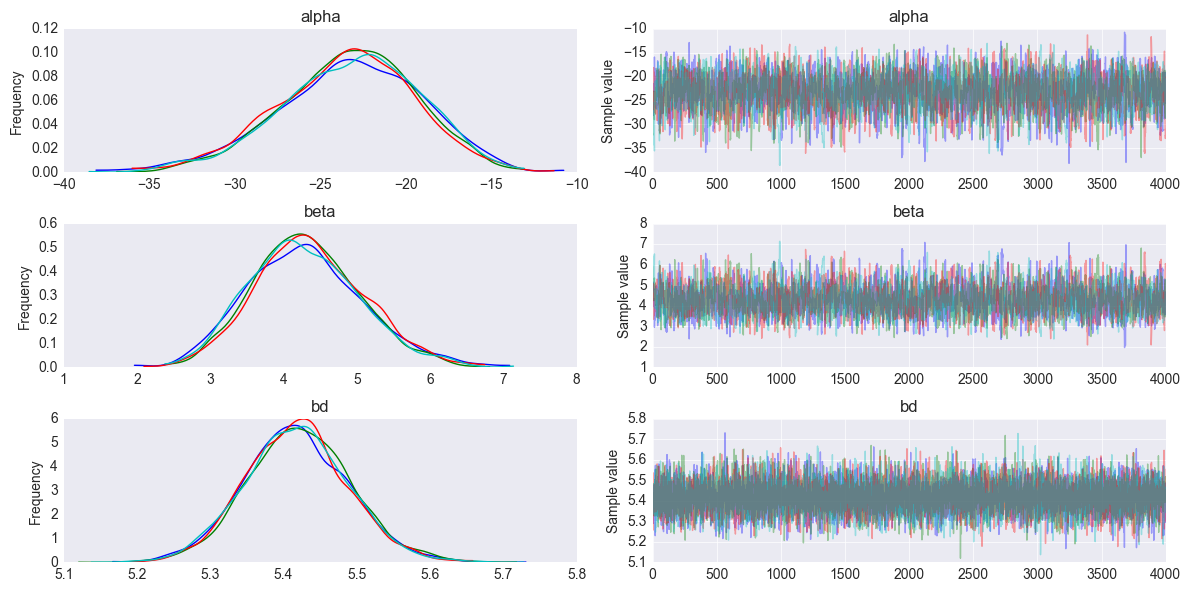

In [4]:
with pm.Model() as model_1:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    # mu is equivalent to z. used with logistic function.
    mu = alpha + pm.math.dot(x_0_f1, beta)
    
    # Note that here we will some x values for theta cuz we have x values for x_0. 
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # this is found by setting mu to 0. Then, bd = -alpha/beta... Se notes page 3 (Next page)
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl_1', theta, observed=y_0)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0_1 = pm.sample(5000, step, start)
    
chain_0_1 = trace_0_1[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_0_1, varnames)

In [5]:
pm.summary(trace_0_1, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.33,4.08,8.05e-02,-31.58,-15.70,2710.0,1.0
beta,4.31,0.76,1.49e-02,2.91,5.84,2721.0,1.0
bd,5.42,0.07,5.64e-04,5.28,5.55,16667.0,1.0


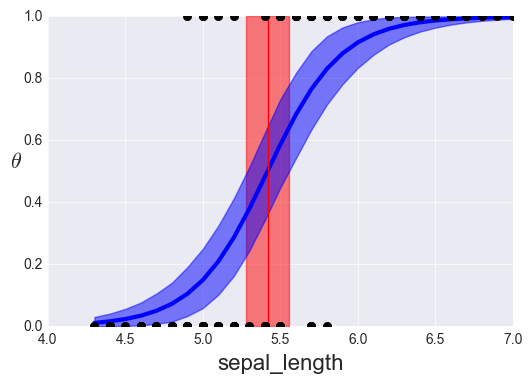

In [6]:
## Model 1 figure

# Note that x_0 shape is (100,), and theta's shape is (20000, 100). 
theta = trace_0_1['theta'].mean(axis=0)

# This will return an array of indices that will make x_0 sorted. 
idx = np.argsort(x_0_f1)

# This alone will print the sigmoid function. (a blue line)
plt.plot(x_0_f1[idx], theta[idx], color='b', lw=3);

# This will print the the red line in the middle which is the mean of the boundary decision. 
plt.axvline(trace_0_1['bd'].mean(), ymax=1, color="r")

bd_hpd = pm.hpd(trace_0_1['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0_f1, y_0, 'o', color='k')

# This will plot the light blue around the sigmoid function
theta_hpd = pm.hpd(trace_0_1['theta'])[idx]
plt.fill_between(x_0_f1[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n_1, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

logp = -8.5369, ||grad|| = 2.6901: 100%|█████████████████████████████████████████████| 20/20 [00:00<00:00, 3988.50it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
There were 529 divergences after tuning. Increase `target_accept` or reparameterize.
There were 331 divergences after tuning. Increase `target_accept` or reparameterize.
There were 536 divergences after tuning. Increase `target_accept` or reparameterize.
There were 221 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F0024C92B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F00261A668>]], dtype=object)

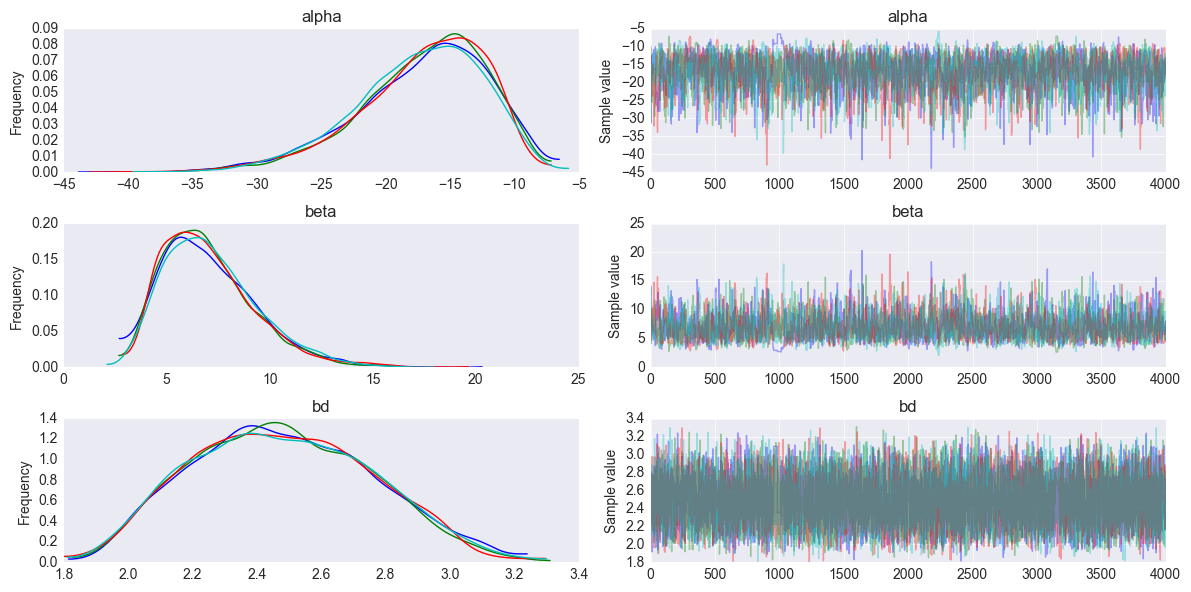

In [7]:
with pm.Model() as model_2:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    # mu is equivalent to z. used with logistic function.
    mu = alpha + pm.math.dot(x_0_f2, beta)
    
    # Note that here we will some x values for theta cuz we have x values for x_0. 
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # this is found by setting mu to 0. Then, bd = -alpha/beta... Se notes page 3 (Next page)
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl_2', theta, observed=y_0)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0_2 = pm.sample(5000, step, start)
    
chain_0_2 = trace_0_2[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_0_2, varnames)

In [8]:
pm.summary(trace_0_2, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-17.25,5.09,1.11e-01,-27.50,-8.67,2318.0,1.0
beta,7.07,2.31,5.00e-02,3.25,11.78,2357.0,1.0
bd,2.48,0.28,2.63e-03,1.97,2.99,11050.0,1.0


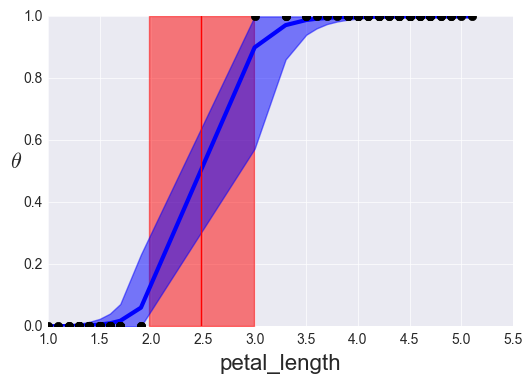

In [9]:
## Model 2 figure

# Note that x_0 shape is (100,), and theta's shape is (20000, 100). 
theta = trace_0_2['theta'].mean(axis=0)

# This will return an array of indices that will make x_0 sorted. 
idx = np.argsort(x_0_f2)

# This alone will print the sigmoid function. (a blue line)
plt.plot(x_0_f2[idx], theta[idx], color='b', lw=3);

# This will print the the red line in the middle which is the mean of the boundary decision. 
plt.axvline(trace_0_2['bd'].mean(), ymax=1, color="r")

bd_hpd = pm.hpd(trace_0_2['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0_f2, y_0, 'o', color='k')

# This will plot the light blue around the sigmoid function
theta_hpd = pm.hpd(trace_0_2['theta'])[idx]
plt.fill_between(x_0_f2[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n_2, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

logp = -8.3516, ||grad|| = 0.0049936: 100%|██████████████████████████████████████████| 14/14 [00:00<00:00, 3490.89it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.890974845248, but should be close to 0.8. Try to increase the number of tuning steps.
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F002CACF28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F0053A7390>]], dtype=object)

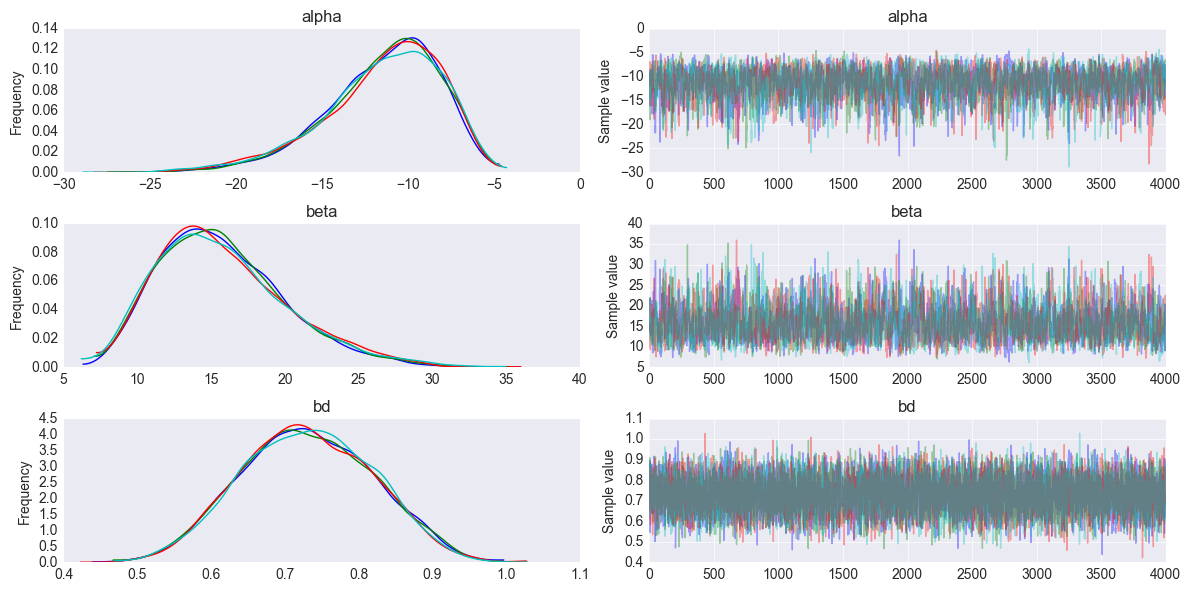

In [10]:
with pm.Model() as model_3:
    
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    # mu is equivalent to z. used with logistic function.
    mu = alpha + pm.math.dot(x_0_f3, beta)
    
    # Note that here we will some x values for theta cuz we have x values for x_0. 
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # this is found by setting mu to 0. Then, bd = -alpha/beta... Se notes page 3 (Next page)
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl_3', theta, observed=y_0)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0_3 = pm.sample(5000, step, start)
    
chain_0_3 = trace_0_3[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_0_3, varnames)

In [11]:
pm.summary(trace_0_3, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-11.49,3.39,6.11e-02,-18.12,-5.51,2411.0,1.0
beta,15.80,4.38,7.73e-02,8.31,24.65,2420.0,1.0
bd,0.73,0.09,7.43e-04,0.56,0.90,15016.0,1.0


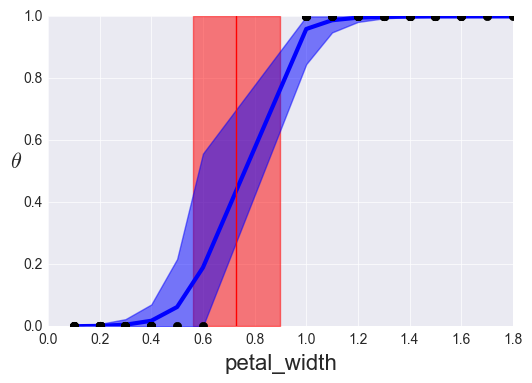

In [12]:
## Model 3 figure

# Note that x_0 shape is (100,), and theta's shape is (20000, 100). 
theta = trace_0_3['theta'].mean(axis=0)

# This will return an array of indices that will make x_0 sorted. 
idx = np.argsort(x_0_f3)

# This alone will print the sigmoid function. (a blue line)
plt.plot(x_0_f3[idx], theta[idx], color='b', lw=3);

# This will print the the red line in the middle which is the mean of the boundary decision. 
plt.axvline(trace_0_3['bd'].mean(), ymax=1, color="r")

bd_hpd = pm.hpd(trace_0_3['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0_f3, y_0, 'o', color='k')

# This will plot the light blue around the sigmoid function
theta_hpd = pm.hpd(trace_0_3['theta'])[idx]
plt.fill_between(x_0_f3[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n_3, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

## Conclusion:

As we can see from the graphs above, the samples are already seperated when considering petal length and petal width, which is not the case while using sepal length. Hence, classifying the flowers based on petal width or petal length makes the classification problem easy. On the other hand, when using sepal length, we have to chose a boundary decision and some samples will not be classified correctly. The decision boundary when using petal width is shifted a little bit to the left, that is, to the side where we have less data. Almost the same situation happens with petal length. 

Additionally, we can see that we have a larger decision boundary when considering the petal length and petal width features which is normal since we have less data point that are more seperated from each other (based on the feature). In other words, if we consider petal width, the decision boundary can range from ~0.6 to ~1, hence we get large confidence interval. Same with petal length feature.

## Problem 2
Repeat exercise 1, this time using a Student's t-distribution as weakly
informative prior. Try different value of ν .

I ran the model twice, once when nu is 3 and another time when its 20. Please note that nu is related to the degrees of freedom which is equal to n - 1. The nu in general control how normal the distribution looks like. So when nu is infinite, the scale will be equal to the standard deviation, and hence get a normal distribution. It is better to chose nu that is smaller than 30, otherwise, we will become confident about our answers. Therefore, we will see that as we increase nu, we will get results similar to the one approched in the first problem.

logp = -8.8016, ||grad|| = 2.6751: 100%|█████████████████████████████████████████████| 20/20 [00:00<00:00, 3989.64it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
There were 1472 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.601927585311, but should be close to 0.8. Try to increase the number of tuning steps.
There were 973 divergences after tuning. Increase `target_accept` or reparameterize.
There were 790 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001731B172FD0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000017317BD3390>]], dtype=object)

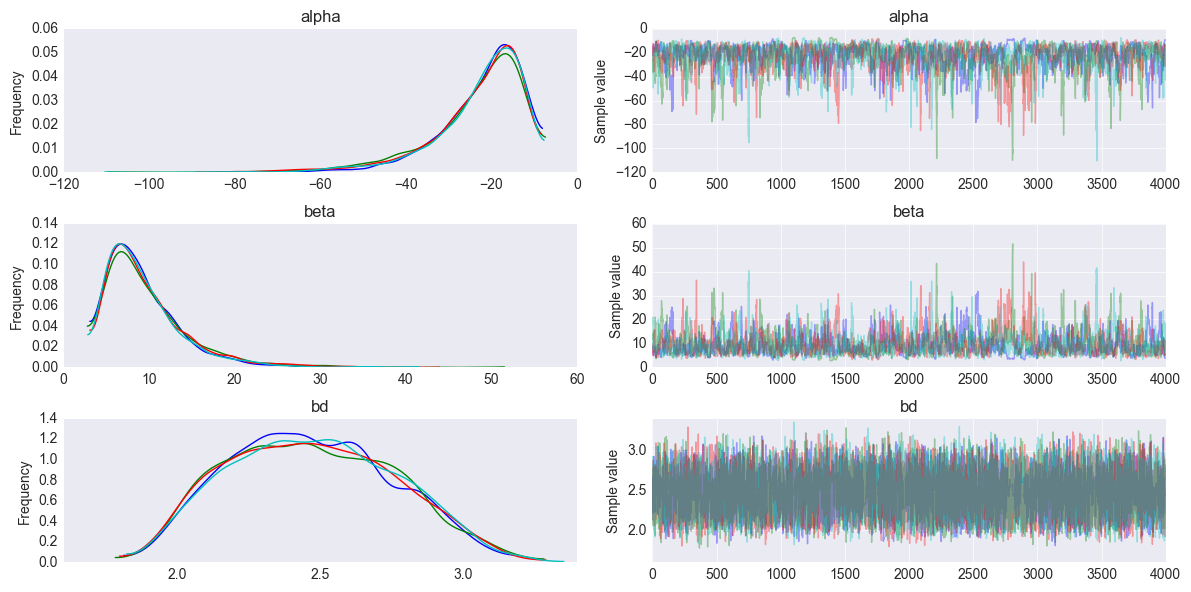

In [27]:
with pm.Model() as model_t2:
    
    # It is usggested that this parameter is between 3 and 7, hence 5 is picked. 
    alpha = pm.StudentT('alpha', nu=3, mu=0, sd=10)
    beta = pm.StudentT('beta', nu=3, mu=0, sd=10)
    
    # mu is equivalent to z. used with logistic function.
    mu = alpha + pm.math.dot(x_0_f2, beta)
    
    # Note that here we will some x values for theta cuz we have x values for x_0. 
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # this is found by setting mu to 0. Then, bd = -alpha/beta... Se notes page 3 (Next page)
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', theta, observed=y_0)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0_t2 = pm.sample(5000, step, start)
    
chain_0_t2 = trace_0_t2[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_0_t2, varnames)

In [29]:
pm.summary(trace_0_t2, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.11,10.73,3.51e-01,-43.84,-7.89,909.0,1.0
beta,9.52,4.63,1.53e-01,3.06,18.60,909.0,1.0
bd,2.47,0.29,2.58e-03,1.96,3.01,11343.0,1.0


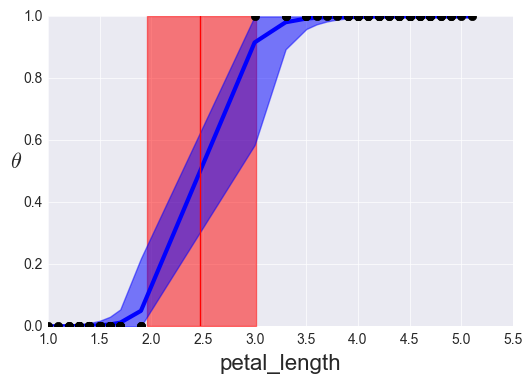

In [30]:
## Model t1 figure

theta = trace_0_t2['theta'].mean(axis=0)

# This will return an array of indices that will make x_0 sorted. 
idx = np.argsort(x_0_f2)

# This alone will print the sigmoid function. (a blue line)
plt.plot(x_0_f2[idx], theta[idx], color='b', lw=3);

# This will print the the red line in the middle which is the mean of the boundary decision. 
plt.axvline(trace_0_t2['bd'].mean(), ymax=1, color="r")

bd_hpd = pm.hpd(trace_0_t2['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0_f2, y_0, 'o', color='k')

# This will plot the light blue around the sigmoid function
theta_hpd = pm.hpd(trace_0_t2['theta'])[idx]
plt.fill_between(x_0_f2[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n_2, fontsize=16)
plt.ylabel(r'$\theta$', rotation=0, fontsize=16)

logp = -8.57, ||grad|| = 2.6882: 100%|███████████████████████████████████████████████| 20/20 [00:00<00:00, 3988.31it/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
There were 263 divergences after tuning. Increase `target_accept` or reparameterize.
There were 426 divergences after tuning. Increase `target_accept` or reparameterize.
There were 992 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.668845206317, but should be close to 0.8. Try to increase the number of tuning steps.
There were 444 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001731D8E20F0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001731615FB70>]], dtype=object)

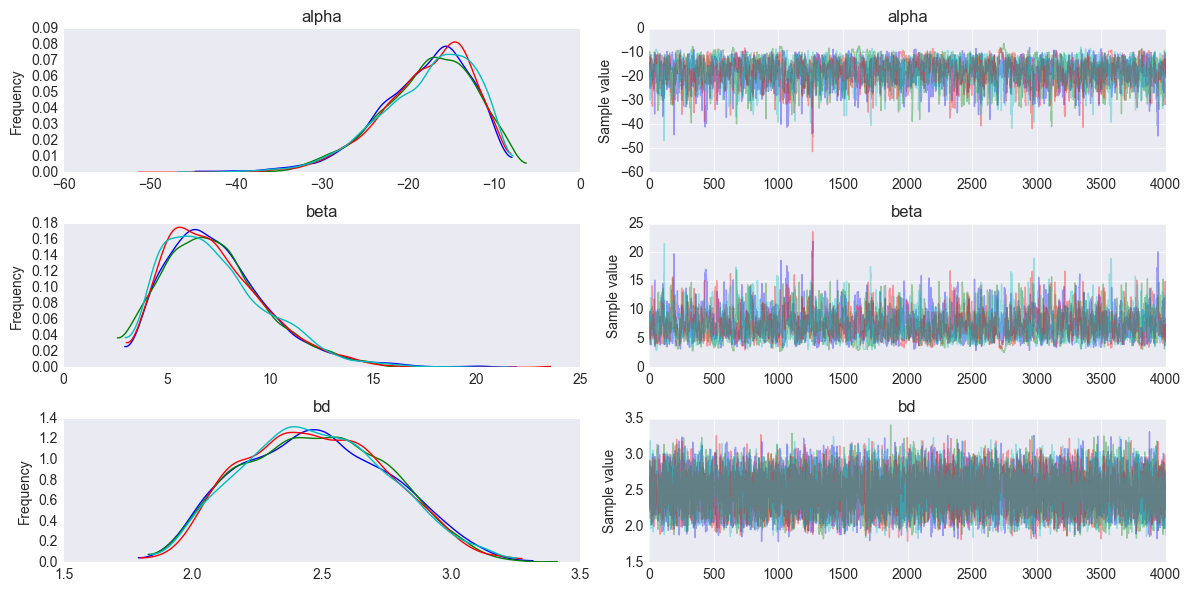

In [38]:
with pm.Model() as model_t2:
    
    # It is usggested that this parameter is between 3 and 7, hence 5 is picked. 
    alpha = pm.StudentT('alpha', nu=25, mu=0, sd=10)
    beta = pm.StudentT('beta', nu=25, mu=0, sd=10)
    
    # mu is equivalent to z. used with logistic function.
    mu = alpha + pm.math.dot(x_0_f2, beta)
    
    # Note that here we will some x values for theta cuz we have x values for x_0. 
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    # this is found by setting mu to 0. Then, bd = -alpha/beta... Se notes page 3 (Next page)
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', theta, observed=y_0)
    
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_0_t2 = pm.sample(5000, step, start)
    
chain_0_t2 = trace_0_t2[1000:]
varnames = ['alpha', 'beta', 'bd']
pm.traceplot(chain_0_t2, varnames)

In [40]:
pm.summary(trace_0_t2, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-17.87,5.52,1.18e-01,-28.52,-8.60,1916.0,1.0
beta,7.33,2.50,5.20e-02,3.24,12.24,1990.0,1.0
bd,2.48,0.28,2.43e-03,1.97,2.99,11533.0,1.0


Therefore, we get similar results to problem 1 when we assumed gaussian priors and taking into account the second feature. 

## Question 5
In the example for dealing with unbalanced data, change df = df[45: ] to
df[22:78] . This will keep roughly the same number of data points, but now
the classes will be balanced. Compare the new result with the previous ones.
Which one is more similar to the example using the complete dataset?

## a) 

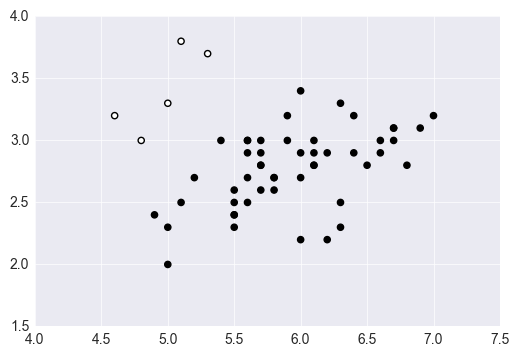

In [2]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
df = df[45:]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [10]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic link function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    db = pm.Deterministic('db', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.882519884967, but should be close to 0.8. Try to increase the number of tuning steps.
There were 17 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017312968908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000017312A26F60>]], dtype=object)

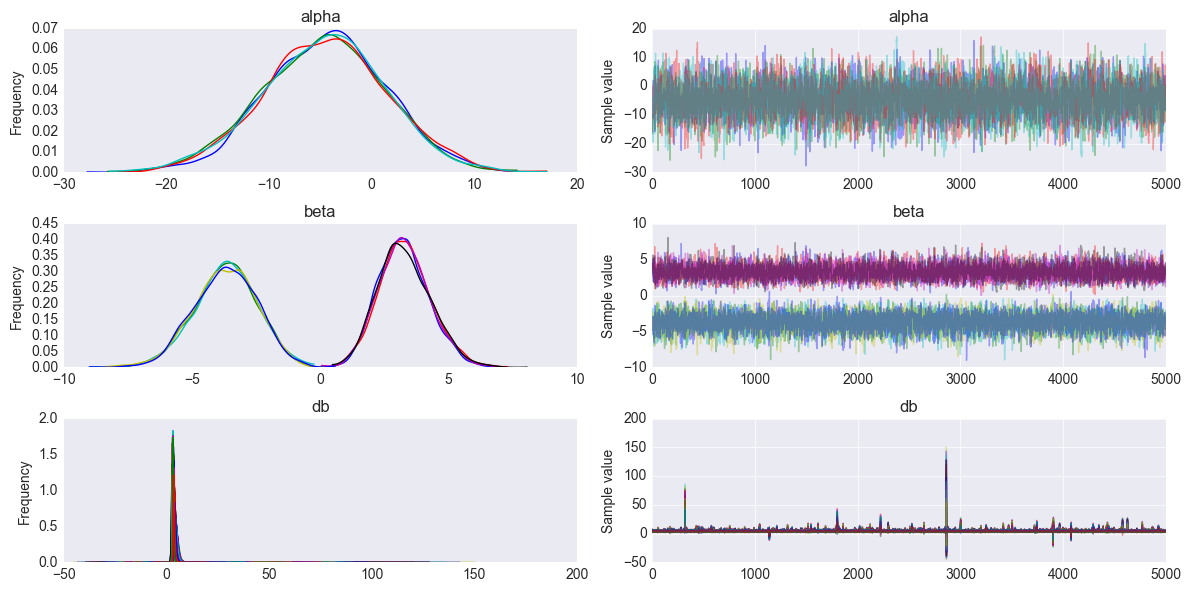

In [11]:
pm.traceplot(trace_3)

In [12]:
pm.summary(trace_3, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-4.63,6.00,0.08,-16.91,6.79,5564.0,1.0
beta__0,3.28,1.01,0.01,1.38,5.33,5649.0,1.0
beta__1,-3.71,1.24,0.01,-6.05,-1.26,6483.0,1.0


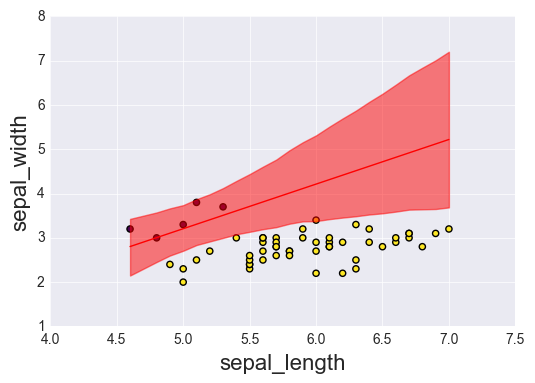

In [15]:
idx = np.argsort(x_3[:,0])
# For each data point, find the mean posterior decision boundary
db = trace_3['db'].mean(0)[idx]
# plot initial data points. 
plt.scatter(x_3[:,0], x_3[:,1], c=y_3, cmap='viridis')
plt.plot(x_3[:,0][idx], db, color='r');

# Compute hpd and plot it on the graph (this will plot the 95% CI around the mean of the posterior for for each data point)
db_hpd = pm.hpd(trace_3['db'])[idx]
plt.fill_between(x_3[:,0][idx], db_hpd[:,0], db_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)

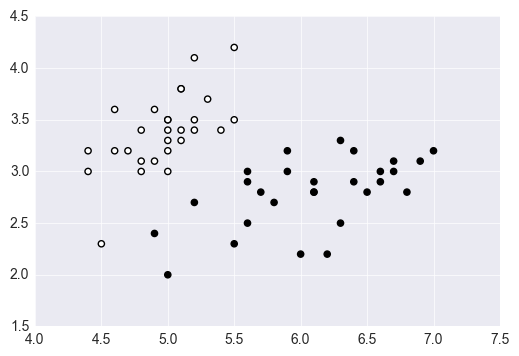

In [16]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
df = df[22:78]
y_3 = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width'] 
x_3 = df[x_n].values
plt.scatter(x_3[:,0], x_3[:,1], c=y_3)

In [17]:
with pm.Model() as model_3:
    # We define the a prioris
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    
    mu = alpha + pm.math.dot(x_3, beta)
    # Aplly the logistic link function
    p = 1 / (1 + pm.math.exp(-mu))
    # Compute the boundary decision
    db = pm.Deterministic('db', -alpha/beta[1] - beta[0]/beta[1] * x_3[:,0])
    
    # Define the likelihood
    yl = pm.Bernoulli('yl', p=p, observed=y_3)
    trace_3 = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017315A16E80>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000017315B154E0>]], dtype=object)

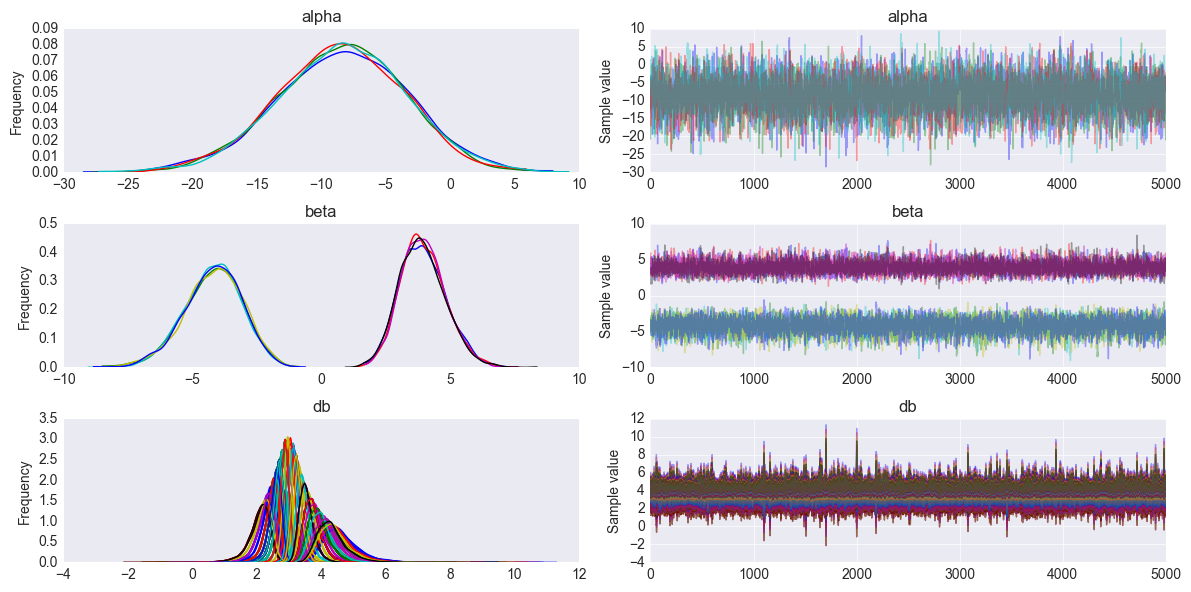

In [18]:
pm.traceplot(trace_3)

In [19]:
pm.summary(trace_3, varnames=['alpha', 'beta'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-8.49,5.03,0.06,-18.66,1.15,6690.0,1.0
beta__0,3.95,0.89,0.01,2.27,5.70,6861.0,1.0
beta__1,-4.21,1.13,0.01,-6.41,-2.00,7523.0,1.0


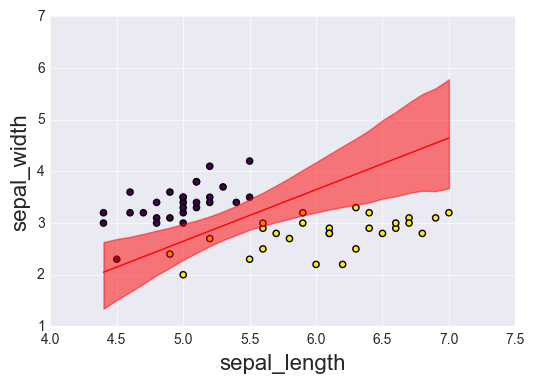

In [20]:
idx = np.argsort(x_3[:,0])
# For each data point, find the mean posterior decision boundary
db = trace_3['db'].mean(0)[idx]
# plot initial data points. 
plt.scatter(x_3[:,0], x_3[:,1], c=y_3, cmap='viridis')
plt.plot(x_3[:,0][idx], db, color='r');

# Compute hpd and plot it on the graph (this will plot the 95% CI around the mean of the posterior for for each data point)
db_hpd = pm.hpd(trace_3['db'])[idx]
plt.fill_between(x_3[:,0][idx], db_hpd[:,0], db_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)

## Conclusion: 

So it is clear that there is a difference between df[45:] and df[22:78]. In the first case, we can see that there are more yellow samples (dots above) which increases the uncertainty and forces the mean of the posterior to be shifted more towards the class that has less data. In the second case, since the samples are almost evenly distributed, the red line was half mid way between both of them. 

# Chapter 5 - Question 6

Compare the likelihood of the logistic model versus the likelihood of the
LDA model. Use the function sample_ppc to generate predicted data and
compare the type of data you get for both cases. Be sure to understand the
difference between the types of data the model predicts.

In [199]:
df = iris[iris['species'].isin(['setosa', 'versicolor'])]
y_6 = pd.Categorical(df['species']).codes
x_6 = 'sepal_length'
x_6 = df[x_6].values

logp = -41.726, ||grad|| = 3.5299e-05: 100%|██████████| 23/23 [00:00<00:00, 1469.94it/s]  
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
100%|██████████| 5500/5500 [00:28<00:00, 189.73it/s]
The acceptance probability does not match the target. It is 0.8790981956288956, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


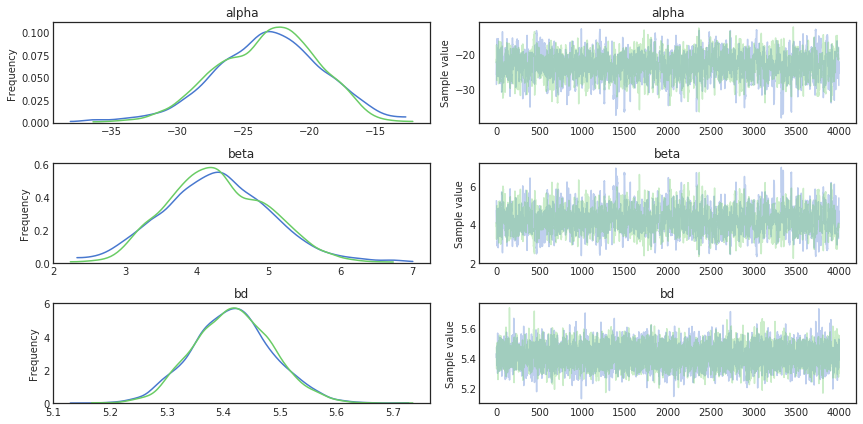

In [200]:
# logistic regression
with pm.Model() as model_lr:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = alpha + pm.math.dot(x_6, beta)
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic('bd', -alpha/beta)
    yl = pm.Bernoulli('yl', theta, observed=y_6)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_61 = pm.sample(5000, step, start, cores=1)
    chain_61 = trace_61[1000:]
    varnames = ['alpha', 'beta', 'bd']
    pm.traceplot(chain_61, varnames)

In [201]:
pm.summary(chain_61, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.17,3.94,1.12e-01,-30.76,-15.77,1163.0,1.0
beta,4.28,0.73,2.07e-02,2.87,5.66,1163.0,1.0
bd,5.42,0.07,9.32e-04,5.28,5.56,6491.0,1.0


In [202]:
# compute likelihood of logistric regression
likelihood_lr=np.sum(chain_61['theta'].mean(axis=0))
print("The likelihood of the logistric regression model is: {0}".format(likelihood_lr))

The likelihood of the logistric regression model is: 50.23730043020029


In [203]:
# sample from the logistric regression model    
xp_61=pm.sample_ppc(trace_61, samples=100, model=model_lr)
print(xp_61)

100%|██████████| 100/100 [00:00<00:00, 1215.66it/s]

{'yl': array([[1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])}


xp_61 contains in fact class labels {0,1}. This is because logistic regression models directly model the posterior of y: p(y|x) which is Bernoulli. That is to say, we cannot sample feature data (x) from discriminative models.

logp = -67.038, ||grad|| = 1.4918: 100%|██████████| 37/37 [00:00<00:00, 1613.73it/s]  
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigmas_interval__, mus]
100%|██████████| 5500/5500 [00:07<00:00, 745.22it/s]
The acceptance probability does not match the target. It is 0.8821818886457652, but should be close to 0.8. Try to increase the number of tuning steps.


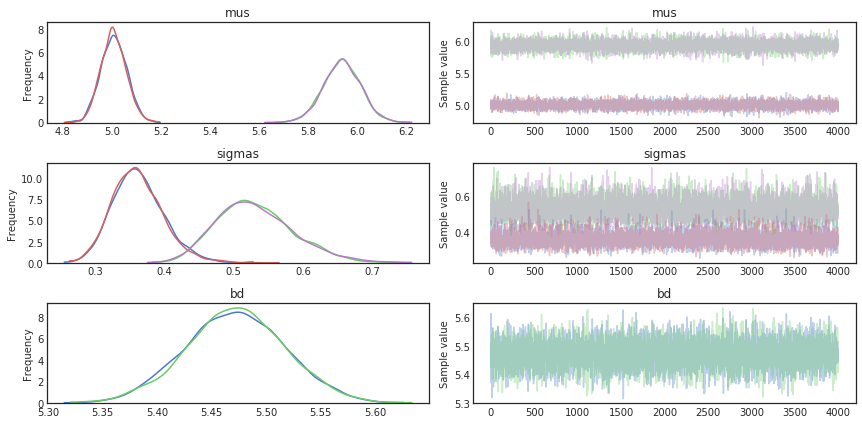

In [204]:
# LDA
with pm.Model() as lda:
    mus = pm.Normal('mus', mu=0, sd=10, shape=2)
    sigmas = pm.Uniform('sigmas', 0, 10, shape=2)
    setosa = pm.Normal('setosa', mu=mus[0], sd=sigmas[0], observed=x_6[:50])
    versicolor = pm.Normal('versicolor', mu=mus[1], sd=sigmas[1], observed=x_6[50:])
    bd = pm.Deterministic('bd', (mus[0]+mus[1])/2)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_62 = pm.sample(5000, step, start)
    chain_62 = trace_62[1000:]
    varnames = ['mus', 'sigmas', 'bd']
    pm.traceplot(chain_62, varnames)

In [205]:
pm.summary(chain_62, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,5.01,0.05,4.79e-04,4.91,5.11,8000.0,1.0
mus__1,5.94,0.08,7.57e-04,5.79,6.08,8000.0,1.0
sigmas__0,0.36,0.04,4.22e-04,0.29,0.43,8000.0,1.0
sigmas__1,0.53,0.06,5.55e-04,0.43,0.64,8000.0,1.0
bd,5.47,0.05,4.54e-04,5.38,5.56,8000.0,1.0


In [206]:
# compute likelihood of LDA, assume p(x) and p(y) are constants, we hve p(y|x,param) proportional to p(x|y)
mu0=chain_62["mus"][0].mean(axis=0)
mu1=chain_62["mus"][1].mean(axis=0)
sigma0=chain_62["sigmas"][0].mean(axis=0)
sigma1=chain_62["sigmas"][1].mean(axis=0)

In [207]:
likelihood_lda = 0
x6_0=x_6[:50] # data for sigmas class
likelihood_lda = likelihood_lda + np.sum( norm.pdf(x6_0, mu0,sigma0) )
x6_1=x_6[50:] # data for sigmas class
likelihood_lda = likelihood_lda + np.sum( norm.pdf(x6_1, mu1,sigma1) )
print("The likelihood of the LDA model is proportional to: {0}".format(likelihood_lda))

The likelihood of the LDA model is proportional to: 51.632078368759174


In [208]:
# sample from the generative model
xp_62=pm.sample_ppc(trace_62, samples=100, model=lda, size=100)
print(xp_62)

100%|██████████| 100/100 [00:00<00:00, 413.53it/s]

{'versicolor': array([[5.45, 6.25, 6.47, ..., 6.68, 5.2 , 6.27],
       [5.47, 5.81, 6.5 , ..., 5.55, 6.79, 6.23],
       [6.35, 5.65, 5.63, ..., 6.53, 5.81, 6.12],
       ...,
       [5.91, 6.01, 5.7 , ..., 6.57, 4.65, 5.84],
       [5.19, 5.96, 6.26, ..., 5.95, 5.04, 5.16],
       [6.61, 6.54, 5.82, ..., 5.73, 6.14, 5.51]]), 'setosa': array([[5.3 , 5.06, 4.58, ..., 5.39, 4.52, 5.06],
       [4.69, 4.8 , 5.43, ..., 5.46, 5.34, 4.96],
       [4.62, 4.37, 5.54, ..., 4.69, 5.41, 5.19],
       ...,
       [5.62, 4.66, 5.1 , ..., 5.95, 5.45, 5.18],
       [4.84, 5.03, 4.85, ..., 4.5 , 5.49, 5.09],
       [4.51, 4.7 , 4.76, ..., 5.5 , 5.56, 4.99]])}


Different from discriminative models, we can sample feature data (x) from generative models.
xp_62 contains feature data from the two class respectively. This is because the generative model models the class conditional distributions: p(x|y) (and assume constant priors on y).

# Problem 3: 

IQ test is performed on n people m times each. The data are the measures $ X_{ij} $ for the i = 1, . . . , n people and their j = 1, . . . , m 
repeated test scores. The model can be presented as below. Please use $\sigma^2$ in the model and not $1/\sigma^2$ as in the figure.

![alt text](image.png "Title")

Assume that we got the following test scores for 3 people: (90, 95, 100), (105, 110, 115), and (150, 155, 160).
    
(a) Use the posterior distribution for each person’s $ \mu_{i} $ to estimate their IQ. What can we say about the precision of the IQ test?

(b) Use mean of 100 and standard deviation of 15 for $\mu$. Repeat question (a)

(c) Repeat both of the above stages (i.e., using both priors on $\mu_{i}$) with a new, but closely related, data set that has scores of 
(94, 95, 96), (109, 110, 111), and (154, 155, 156). How do the different prior assumptions affect IQ estimation for these data. 
Why does it not follow the same pattern as the previous data?



In [209]:
# Answer to (a)
x1=np.array([90, 95, 100],dtype=float)
x2=np.array([105, 110, 115],dtype=float)
x3=np.array([150, 155, 160],dtype=float)
x=np.concatenate((x1,x2,x3))
idx=np.array([0,0,0,1,1,1,2,2,2])

with pm.Model() as iq1:
    mus=pm.Uniform('mus', 0, 300, shape=3)
    sigma=pm.Uniform('sigma',0,100)
    likelihood=pm.Normal('likelihood', mu=mus[idx], sd=sigma, observed=x)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_bonus1 = pm.sample(5000, step, start)
    chain_bonus1 = trace_bonus1[1000:]

logp = -47.17, ||grad|| = 5.8332: 100%|██████████| 27/27 [00:00<00:00, 1334.35it/s]  
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mus_interval__]
100%|██████████| 5500/5500 [00:09<00:00, 565.97it/s]
The number of effective samples is smaller than 25% for some parameters.


In [210]:
pm.summary(chain_bonus1)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,95.01,4.11,0.05,86.66,102.85,6741.0,1.0
mus__1,109.97,4.26,0.06,102.12,118.01,5259.0,1.0
mus__2,155.03,4.11,0.05,146.95,163.24,6432.0,1.0
sigma,6.55,2.82,0.06,2.79,11.43,1822.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2c96e7a20>,
      dtype=object)

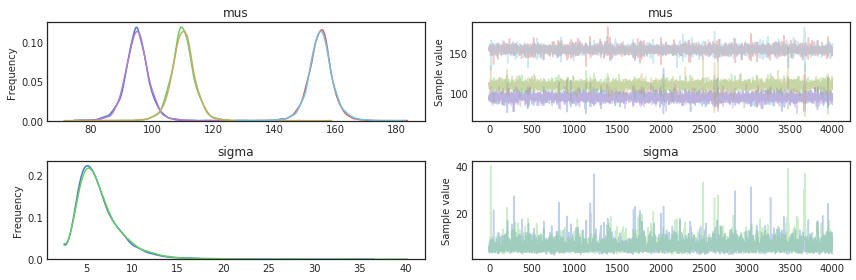

In [211]:
pm.traceplot(chain_bonus1)

Using the posterior of mus, we estimate their IQ. We can say that the posterior estimates are similar to the sample means/medians, with standard deviation of about 4.


In [212]:
# Answer to (b)
with pm.Model() as iq2:
    mus=pm.Normal('mus', mu=100, sd=15, shape=3)
    sigma=pm.Uniform('sigma',0,100)
    likelihood=pm.Normal('likelihood', mu=mus[idx], sd=sigma, observed=x)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_bonus2 = pm.sample(5000, step, start)
    chain_bonus2 = trace_bonus2[1000:]

logp = -47.748, ||grad|| = 0.19274: 100%|██████████| 27/27 [00:00<00:00, 1272.94it/s]  
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mus]
100%|██████████| 5500/5500 [00:11<00:00, 484.40it/s]
The number of effective samples is smaller than 25% for some parameters.


In [213]:
pm.summary(chain_bonus2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,95.47,4.54,0.08,86.78,104.95,3291.0,1.0
mus__1,109.13,4.57,0.07,100.14,118.51,3939.0,1.0
mus__2,150.00,6.94,0.19,135.20,160.03,1407.0,1.0
sigma,7.82,4.84,0.14,2.83,16.03,1206.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2c8f676d8>,
      dtype=object)

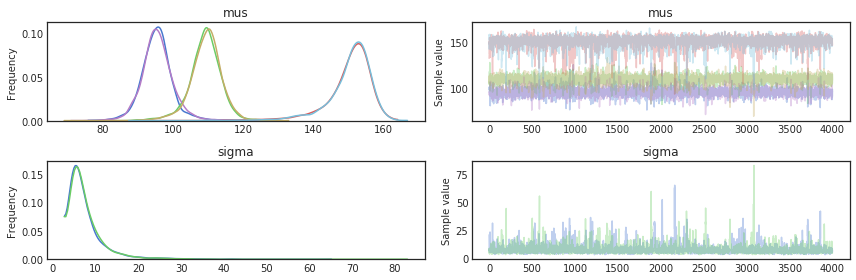

In [214]:
pm.traceplot(chain_bonus2)

Larger sigma and sd are obtained. Wider HPDs are obtained.

In [215]:
# Answer to (c)
x1=np.array([94, 95, 96],dtype=float)
x2=np.array([109, 110, 111],dtype=float)
x3=np.array([154, 155, 156],dtype=float)
x=np.concatenate((x1,x2,x3))
idx=np.array([0,0,0,1,1,1,2,2,2])

with pm.Model() as iq3:
    mus=pm.Uniform('mus', 0, 300, shape=3)
    sigma=pm.Uniform('sigma',0,100)
    likelihood=pm.Normal('likelihood', mu=mus[idx], sd=sigma, observed=x)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_bonus3 = pm.sample(5000, step, start)
    chain_bonus3 = trace_bonus3[1000:]

logp = -32.662, ||grad|| = 0.00082358: 100%|██████████| 42/42 [00:00<00:00, 1548.80it/s]  
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mus_interval__]
100%|██████████| 5500/5500 [00:09<00:00, 593.59it/s]


In [216]:
pm.summary(chain_bonus3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,95.01,0.81,0.01,93.39,96.61,5760.0,1.0
mus__1,109.98,0.82,0.01,108.49,111.73,5033.0,1.0
mus__2,154.99,0.82,0.01,153.44,156.73,6895.0,1.0
sigma,1.31,0.56,0.01,0.61,2.31,2624.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2d9d56278>,
      dtype=object)

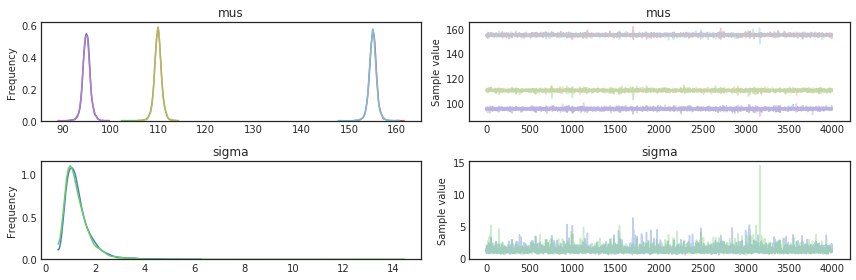

In [217]:
pm.traceplot(chain_bonus3)    

In [218]:
with pm.Model() as iq4:
    mus=pm.Normal('mus', mu=100, sd=15, shape=3)
    sigma=pm.Uniform('sigma',0,100)
    likelihood=pm.Normal('likelihood', mu=mus[idx], sd=sigma, observed=x)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace_bonus4 = pm.sample(5000, step, start)
    chain_bonus4 = trace_bonus4[1000:]

logp = -33.762, ||grad|| = 2.5298: 100%|██████████| 31/31 [00:00<00:00, 1339.34it/s]  
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, mus]
100%|██████████| 5500/5500 [00:08<00:00, 644.97it/s]
The acceptance probability does not match the target. It is 0.8928888237636904, but should be close to 0.8. Try to increase the number of tuning steps.


In [219]:
pm.summary(chain_bonus4)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mus__0,95.02,0.80,1.08e-02,93.48,96.64,5899.0,1.0
mus__1,109.96,0.82,1.01e-02,108.35,111.69,6177.0,1.0
mus__2,154.84,0.84,9.34e-03,153.13,156.43,6315.0,1.0
sigma,1.30,0.53,9.58e-03,0.58,2.31,2674.0,1.0


In [ ]:
pm.traceplot(chain_bonus4)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc2c9a9cc88>,
      dtype=object)

The Uniform prior on mu and the Normal prior on mu obtained similar results. Prior should be selected according to the variability of data. In largely dispersed data, an informative prior may not be a good choice.
